In [1]:
import numpy as np
import py3Dmol
import networkx as nx
from Bio.PDB import PDBParser

import numpy as np
import py3Dmol
import networkx as nx
from Bio.PDB import PDBParser, PDBIO
from io import StringIO

def structure_to_pdb_string(structure):
    """
    Convert BioPython structure to PDB string
    """
    pdbio = PDBIO()
    pdbio.set_structure(structure)
    
    # Use StringIO to capture PDB output
    output = StringIO()
    pdbio.save(output)
    return output.getvalue()

def get_aromatic_centers(structure):
    """
    Extract centers of aromatic rings across all chains
    """
    aromatic_residues = ['PHE', 'TYR', 'TRP', 'HIS']
    aromatic_centers = {}

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() in aromatic_residues:
                    center = calculate_aromatic_center(residue)
                    if center is not None:
                        aromatic_centers[f"{chain.id}_{residue.get_full_id()[3][1]}"] = center
    
    return aromatic_centers

def calculate_aromatic_center(residue):
    """
    Calculate the geometric center of the aromatic ring
    """
    ring_atoms = {
        'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
        'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
        'TRP': ['CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
        'HIS': ['CG', 'ND1', 'CD2', 'CE1', 'NE2']
    }
    
    try:
        atoms = [residue[atom_name] for atom_name in ring_atoms[residue.get_resname()]]
        coords = np.array([atom.coord for atom in atoms])
        return np.mean(coords, axis=0)
    except:
        return None

def edge_distance(point1, point2):
    """
    Calculate edge-to-edge distance between two points
    """
    return np.linalg.norm(point1 - point2)

def build_proximity_graph(aromatic_centers):
    """
    Build a graph of aromatic centers based on proximity
    """
    G = nx.Graph()
    for name1, center1 in aromatic_centers.items():
        G.add_node(name1, pos=center1)
    
    for name1, center1 in aromatic_centers.items():
        for name2, center2 in aromatic_centers.items():
            if name1 != name2:
                dist = edge_distance(center1, center2)
                G.add_edge(name1, name2, weight=dist)
    return G

def visualize_path(structure, aromatic_centers, shortest_path):
    """
    Visualize protein structure with path and aromatics
    """
    # Convert structure to PDB string
    pdb_string = structure_to_pdb_string(structure)
    
    view = py3Dmol.view(width=800, height=600)
    
    # Add ribbon structure in transparent blue
    view.addModel(pdb_string, 'pdb')
    view.setStyle({'cartoon': {'color': 'blue', 'opacity': 0.5}})
    
    # Add aromatic residues in stick form
    for res_name in aromatic_centers.keys():
        chain, res_num = res_name.split('_')
        view.setStyle({'chain': chain, 'resi': int(res_num), 'resn': ['PHE', 'TYR', 'TRP', 'HIS']}, 
                      {'stick': {'color': 'green'}})
    
    # Color path based on distances
    path_points = [aromatic_centers[node] for node in shortest_path]
    for i in range(len(path_points) - 1):
        dist = edge_distance(path_points[i], path_points[i+1])
        color = 'green' if dist <= 0.8 else 'yellow' if dist <= 1.0 else 'orange' if dist <= 1.2 else 'red'
        
        view.addCylinder({
            'start': {'x': float( path_points[i][0]), 'y': float( path_points[i][1]), 'z': float( path_points[i][2])},
            'end': {'x': float(path_points[i+1][0]), 'y': float( path_points[i+1][1]), 'z': float( path_points[i+1][2])},
            'radius': 0.1,
            'color': color
        })
    
    view.zoomTo()
    view.render()
    return view

def find_shortest_aromatic_path(pdb_file, start_chain, start_residue, end_chain, end_residue):
    """
    Main function to find and visualize shortest path between aromatics
    """
    # Parse PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    
    # Get aromatic centers
    aromatic_centers = get_aromatic_centers(structure)
    
    # Build proximity graph
    G = build_proximity_graph(aromatic_centers)
    
    # Find shortest path
    start_key = f"{start_chain}_{start_residue}"
    end_key = f"{end_chain}_{end_residue}"
    
    # Verify start and end points exist in aromatic centers
    if start_key not in aromatic_centers:
        raise ValueError(f"No aromatic residue found at chain {start_chain}, residue {start_residue}")
    if end_key not in aromatic_centers:
        raise ValueError(f"No aromatic residue found at chain {end_chain}, residue {end_residue}")
    
    shortest_path = nx.shortest_path(G, source=start_key, target=end_key, weight='weight')
    
    # Visualize
    view = visualize_path(structure, aromatic_centers, shortest_path)
    view.show()
    return shortest_path

# Example usage
find_shortest_aromatic_path('proteosome.pdb', 
                             start_chain='D', start_residue=238, 
                             end_chain='G', end_residue=231)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

['D_238', 'G_231']

In [7]:
import numpy as np
import py3Dmol
import networkx as nx
import numpy as np
import py3Dmol
import networkx as nx
from itertools import islice

class AromaticPathfinder:
    def __init__(self, pdb_file):
        from Bio.PDB import PDBParser, PDBIO
        from io import StringIO

        # Parse PDB
        parser = PDBParser(QUIET=True)
        self.structure = parser.get_structure('protein', pdb_file)
        
        # Convert structure to PDB string
        pdbio = PDBIO()
        pdbio.set_structure(self.structure)
        output = StringIO()
        pdbio.save(output)
        self.pdb_string = output.getvalue()

        # Van der Waals radii (in Angstroms)
        self.vdw_radii = {
            'C': 1.7,
            'N': 1.55,
            'O': 1.52,
            'H': 1.2
        }

    def _get_ring_atoms(self, residue):
        """
        Get atoms that form the aromatic ring
        """
        ring_atoms = {
            'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
            'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
            'TRP': ['CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
            'HIS': ['CG', 'ND1', 'CD2', 'CE1', 'NE2'],
            'BTN' : ['C2','C3','C4','C5','C6']
        }
        
        try:
            return [residue[atom_name] for atom_name in ring_atoms[residue.get_resname()]]
        except:
            return None

    def _get_aromatic_centers(self):
        """
        Extract centers and atoms of aromatic rings across all chains
        """
        aromatic_residues = ['PHE',  'TYR', 'TRP', 'BTN']
        aromatics = {}

        for model in self.structure:
            for chain in model:
                for residue in chain:
                    #print(f'chain: {chain.id}, residue: {residue.id[1]} {residue.get_resname()}')
                    if residue.get_resname() in aromatic_residues:
                       
                        ring_atoms = self._get_ring_atoms(residue)
                        if ring_atoms:
                            coords = np.array([atom.coord for atom in ring_atoms])
                            center = np.mean(coords, axis=0)
                            key = f"{chain.id}_{residue.id[1]}"
                            aromatics[key] = {
                                'center': center,
                                'residue': residue.get_resname(),
                                'ring_atoms': ring_atoms
                            }
        
        return aromatics

    def _calculate_edge_distance(self, atoms1, atoms2):
        """
        Calculate minimum edge-to-edge distance between two sets of atoms
        considering van der Waals radii
        """
        min_distance = float('inf')
        min_atoms = []
        for atom1 in atoms1:
            for atom2 in atoms2:
                if atom1.element == 'C' and atom2.element == 'C':
                    # Get centers
                    pos1 = atom1.coord
                    pos2 = atom2.coord
                    
                    # Calculate center-to-center distance
                    center_dist = np.linalg.norm(pos1 - pos2)
                    
                    # Subtract vdW radii
                    vdw1 = self.vdw_radii.get(atom1.element, 1.7)  # default to carbon
                    vdw2 = self.vdw_radii.get(atom2.element, 1.7)
                    
                    edge_dist = center_dist #- (vdw1 + vdw2)
                    if edge_dist < min_distance:
                        min_atoms = [atom1, atom2]
                        min_distance =  edge_dist
        
        return min_distance,min_atoms

    def find_multiple_paths(self, start_chain, start_residue, end_chain, end_residue, num_paths=3, energy_factor=2):
        """
        Find multiple shortest paths considering exponential energy cost
        """
        # Get aromatic data
        aromatics = self._get_aromatic_centers()
        
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        for name, data in aromatics.items():
            G.add_node(name, pos=data['center'])
        
        atoms_jumps = {}
        # Add edges with energy-based weight
        for name1, data1 in aromatics.items():
            for name2, data2 in aromatics.items():
                if name1 != name2:
                    # Calculate edge-to-edge distance
                    edge_dist, minAtoms = self._calculate_edge_distance(
                        data1['ring_atoms'],
                        data2['ring_atoms']
                    )
                    
                    # Exponential energy cost
                    energy_cost = edge_dist * (energy_factor ** edge_dist)
                    G.add_edge(name1, name2, weight=energy_cost, distance=edge_dist)
                    atoms_jumps[name1+'_'+name2] = minAtoms
        
        # Find start and end keys
        start_key = f"{start_chain}_{start_residue}"
        end_key = f"{end_chain}_{end_residue}"
        
        # Verify start and end points exist
        if start_key not in aromatics:
            raise ValueError(f"No aromatic residue at chain {start_chain}, residue {start_residue}")
        if end_key not in aromatics:
            raise ValueError(f"No aromatic residue at chain {end_chain}, residue {end_residue}")
        
        # Find k shortest paths
        paths = list(islice(nx.shortest_simple_paths(G, start_key, end_key, weight='weight'), num_paths))
        
        # Visualize each path with a different style
        colors = ['blue', 'red', 'green']  # colors for different paths
        view = self._visualize_multiple_paths(aromatics, paths,atoms_jumps, G, colors[:num_paths])
        view.show()
        
        return paths,view, atoms_jumps

    def _visualize_multiple_paths(self, aromatics, paths,atoms_jumps, graph, path_colors):
        """
        Visualize protein structure with multiple paths and aromatics
        """
        view = py3Dmol.view(width=800, height=800)
        
        # Add ribbon structure in transparent gray
        view.addModel(self.pdb_string, 'pdb')
        view.setStyle({'cartoon': {'color': 'gray', 'opacity': 0.5}})
        
        # Add all aromatic residues in stick form
        for res_name in aromatics:
            chain, res_num = res_name.split('_')
            view.setStyle({'chain': chain, 'resi': int(res_num), 'resn': ['PHE', 'TYR', 'TRP', 'HIS']}, 
                          {'stick': {'color': 'gray', 'opacity': 0.1}})
        
        # Add paths with different colors
        for path, base_color in zip(paths, path_colors):
            for i in range(len(path) - 1):
                point1 = aromatics[path[i]]['center']
                chain1, res_num1 = path[i].split('_')
                resName = aromatics[path[i]]['residue']
                resInitial1 =''
                if resName =="PHE":
                    resInitial1 = 'F'
                elif resName =="TYR":
                    resInitial1 = 'Y'
                elif resName =="TRP":
                    resInitial1 = 'W'
                elif resName =="HIS":
                    resInitial1 = 'H'
                elif resName =="BTN":
                    resInitial1 = 'BTN'
                    
                
                view.setStyle({'chain': chain1, 'resi': int(res_num1), 'resn': ['PHE', 'TYR', 'TRP', 'HIS','BTN']}, 
                          {'stick': {'color': 'green', 'opacity': 1}})
                
                point2 = aromatics[path[i+1]]['center']
                chain2, res_num2 = path[i+1].split('_')
                resName = aromatics[path[i+1]]['residue']
                resInitial2 =''
                if resName =="PHE":
                    resInitial2 = 'F'
                elif resName =="TYR":
                    resInitial2 = 'Y'
                elif resName =="TRP":
                    resInitial2 = 'W'
                elif resName =="HIS":
                    resInitial2 = 'H'
                elif resName =="BTN":
                    resInitial2 = 'BTN'
                    
                # Get edge-to-edge distance from graph
                edge_dist = graph[path[i]][path[i+1]]['distance']
                print(f'{chain1}-{resInitial1}{res_num1}\t{chain2}-{resInitial2}{res_num2}\t{edge_dist}')
                
                # Color based on edge-to-edge distance
                if edge_dist > 12:
                    color = 'red'
                elif edge_dist > 10:
                    color = 'orange'
                elif edge_dist > 8:
                    color = 'yellow'
                else:
                    color = 'green'
                
                view.addCylinder({
                    'start': {'x': float(point1[0]), 'y': float(point1[1]), 'z': float(point1[2])},
                    'end': {'x': float(point2[0]), 'y': float(point2[1]), 'z': float(point2[2])},
                    'radius': 0.75,
                    'color': color,
                    'fromCap': True,
                    'toCap': True,
                    'opacity': 1  # Add transparency
                })
            view.setStyle({'chain': chain2, 'resi': int(res_num2), 'resn': ['PHE', 'TYR', 'TRP', 'HIS','BTN']}, 
                        {'stick': {'color': 'green', 'opacity': 1}})
        view.zoomTo()
        view.render()
       
        return view


finder = AromaticPathfinder('wt-N-avi-relax2.pdb')
 
paths,view,atoms_jumps  = finder.find_multiple_paths('A', 990, 'A', 1734, num_paths=1, energy_factor=2)

A-W990	A-F983	19.658418655395508
A-F983	A-F919	25.647777557373047
A-F919	A-Y924	9.273825645446777
A-Y924	A-F786	8.231246948242188
A-F786	A-Y965	7.924009323120117
A-Y965	A-F882	8.60247802734375
A-F882	A-F835	8.161574363708496
A-F835	A-Y876	7.485435485839844
A-Y876	A-Y867	3.5835254192352295
A-Y867	A-Y1118	3.371314525604248
A-Y1118	A-Y1115	6.253177642822266
A-Y1115	A-Y1366	3.5894739627838135
A-Y1366	A-Y1363	6.891267776489258
A-Y1363	A-Y1614	5.192378520965576
A-Y1614	A-Y1611	3.949376344680786
A-Y1611	A-Y1620	3.4315946102142334
A-Y1620	A-F1579	7.288105487823486
A-F1579	A-F1626	8.438529968261719
A-F1626	A-F1637	5.2321457862854
A-F1637	A-Y1648	6.388079643249512
A-Y1648	A-Y1668	9.97685432434082
A-Y1668	A-F1663	8.86609172821045
A-F1663	A-W1734	12.44604206085205


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
image_data = view.png()


In [6]:
image_data

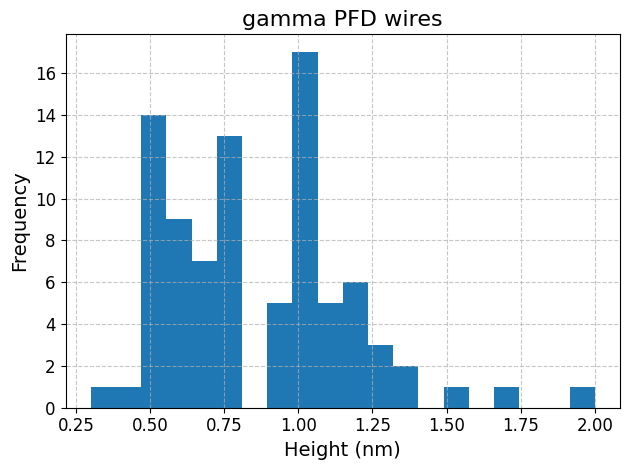

In [26]:
import matplotlib.pyplot as plt
height_nm="""0.8
0.6
0.8
0.6
0.7
0.6
0.5
1
0.6
0.3
0.7
0.7
0.8
0.7
0.5
0.8
1
0.5
0.7
0.5
1
0.8
1
1.2
1.1
0.6
0.8
0.4
0.5
0.9
0.6
0.8
0.6
1.5
1.1
0.8
1.1
1
1.3
0.8
0.5
1
1.7
1
0.5
0.7
0.5
0.5
0.7
1
0.8
1
0.8
1
1
1
0.6
1.2
0.9
0.5
0.5
1.1
0.9
1.2
0.9
2
1.4
0.5
1
1.2
0.8
0.9
1
1.1
1.3
1.2
1
1.3
1.4
0.5
0.6
0.8
1
0.5
1
1.2""".split('\n')
height_nm = [float(x) for x in height_nm]
plt.hist(height_nm, bins=20)
plt.xlabel('Height (nm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('gamma PFD wires', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [36]:
import json

null=None
junctions= {"waferName":"HighDensity2","probes":[{"JunctionName":"UNK0","Orientation":null,"Function":"IVC","Position":"-6260, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK1","Orientation":null,"Function":"IVC","Position":"-5540, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK2","Orientation":null,"Function":"IVC","Position":"-4820, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK3","Orientation":null,"Function":"IVC","Position":"-4100, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK4","Orientation":null,"Function":"IVC","Position":"-3380, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK5","Orientation":null,"Function":"IVC","Position":"-2660, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK6","Orientation":null,"Function":"IVC","Position":"-1940, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK7","Orientation":null,"Function":"IVC","Position":"-1220, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK8","Orientation":null,"Function":"IVC","Position":"-500, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK9","Orientation":null,"Function":"IVC","Position":"220, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK10","Orientation":null,"Function":"IVC","Position":"940, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK11","Orientation":null,"Function":"IVC","Position":"1660, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK12","Orientation":null,"Function":"IVC","Position":"2380, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK13","Orientation":null,"Function":"IVC","Position":"3100, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK14","Orientation":null,"Function":"IVC","Position":"3820, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK15","Orientation":null,"Function":"IVC","Position":"4540, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK16","Orientation":null,"Function":"IVC","Position":"5260, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK17","Orientation":null,"Function":"IVC","Position":"5980, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK18","Orientation":null,"Function":"IVC","Position":"-6260, -6190","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK19","Orientation":null,"Function":"IVC","Position":"-6260, -5470","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK20","Orientation":null,"Function":"IVC","Position":"-6260, -4750","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK21","Orientation":null,"Function":"IVC","Position":"-6260, -4030","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK22","Orientation":null,"Function":"IVC","Position":"-6260, -3310","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK23","Orientation":null,"Function":"IVC","Position":"-6260, -2590","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK24","Orientation":null,"Function":"IVC","Position":"-6260, -1870","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK25","Orientation":null,"Function":"IVC","Position":"-6260, -1150","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK27","Orientation":null,"Function":"IVC","Position":"-6260, -430","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK26","Orientation":null,"Function":"IVC","Position":"-6260, 290","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK28","Orientation":null,"Function":"IVC","Position":"-6260, 1010","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK29","Orientation":null,"Function":"IVC","Position":"-6260, 1730","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK30","Orientation":null,"Function":"IVC","Position":"-6260, 2450","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK31","Orientation":null,"Function":"IVC","Position":"-6260, 3170","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK32","Orientation":null,"Function":"IVC","Position":"-6260, 3890","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK33","Orientation":null,"Function":"IVC","Position":"-6260, 4610","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK34","Orientation":null,"Function":"IVC","Position":"-6260, 5330","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK35","Orientation":null,"Function":"IVC","Position":"-6260, 6050","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK36","Orientation":null,"Function":"IVC","Position":"-6260, 6770","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0}],"activeLayer":"0||1_BE||","uploadedDate":null}
#determine the width and height of the probes using the position.  
#The position is given as a string with the x and y coordinates separated by a comma.
xs=[]
ys=[]
for prob in junctions['probes']:
    x,y = [float(i) for i in prob['Position'].split(',')]
    
    xs.append(x)
    ys.append(y)
cols = 18
rows = 20     
rangeXs = max(xs)-min(xs)
rangeYs = max(ys)-min(ys)
colX = rangeXs/cols
rowY = rangeYs/rows
print(f'width: {max(xs)-min(xs)}')
print(f'height: {max(ys)-min(ys)}')
newProbes = []
for col in range(cols):
  for row in range(rows):
    newProbe = {
      "JunctionName": f"C{col}R{row}",
      "Orientation": null,
      "Function": "IVC",
      "Position": f"{int(min(xs)+col*colX):d}, {int(min(ys)+row*rowY):d}",
      "Area": 0,
      "TopWidth": 0,
      "BottomWidth": 1
    }
    newProbes.append(newProbe)

junctions['probes'] = newProbes
with open('HighDensity.json', 'w') as f:
  json.dump(junctions, f, indent=4)

width: 12240.0
height: 13680.0


In [6]:
import json

null=None
junctions= {"waferName":"HighDensity","probes":[{"JunctionName":"UNK0","Orientation":null,"Function":"IVC","Position":"-6260, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK1","Orientation":null,"Function":"IVC","Position":"-5540, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK2","Orientation":null,"Function":"IVC","Position":"-4820, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK3","Orientation":null,"Function":"IVC","Position":"-4100, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK4","Orientation":null,"Function":"IVC","Position":"-3380, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK5","Orientation":null,"Function":"IVC","Position":"-2660, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK6","Orientation":null,"Function":"IVC","Position":"-1940, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK7","Orientation":null,"Function":"IVC","Position":"-1220, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK8","Orientation":null,"Function":"IVC","Position":"-500, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK9","Orientation":null,"Function":"IVC","Position":"220, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK10","Orientation":null,"Function":"IVC","Position":"940, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK11","Orientation":null,"Function":"IVC","Position":"1660, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK12","Orientation":null,"Function":"IVC","Position":"2380, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK13","Orientation":null,"Function":"IVC","Position":"3100, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK14","Orientation":null,"Function":"IVC","Position":"3820, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK15","Orientation":null,"Function":"IVC","Position":"4540, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK16","Orientation":null,"Function":"IVC","Position":"5260, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK17","Orientation":null,"Function":"IVC","Position":"5980, -6910","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK18","Orientation":null,"Function":"IVC","Position":"-6260, -6190","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK19","Orientation":null,"Function":"IVC","Position":"-6260, -5470","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK20","Orientation":null,"Function":"IVC","Position":"-6260, -4750","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK21","Orientation":null,"Function":"IVC","Position":"-6260, -4030","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK22","Orientation":null,"Function":"IVC","Position":"-6260, -3310","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK23","Orientation":null,"Function":"IVC","Position":"-6260, -2590","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK24","Orientation":null,"Function":"IVC","Position":"-6260, -1870","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK25","Orientation":null,"Function":"IVC","Position":"-6260, -1150","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK27","Orientation":null,"Function":"IVC","Position":"-6260, -430","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK26","Orientation":null,"Function":"IVC","Position":"-6260, 290","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK28","Orientation":null,"Function":"IVC","Position":"-6260, 1010","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK29","Orientation":null,"Function":"IVC","Position":"-6260, 1730","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK30","Orientation":null,"Function":"IVC","Position":"-6260, 2450","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK31","Orientation":null,"Function":"IVC","Position":"-6260, 3170","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK32","Orientation":null,"Function":"IVC","Position":"-6260, 3890","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK33","Orientation":null,"Function":"IVC","Position":"-6260, 4610","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK34","Orientation":null,"Function":"IVC","Position":"-6260, 5330","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK35","Orientation":null,"Function":"IVC","Position":"-6260, 6050","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0},{"JunctionName":"UNK36","Orientation":null,"Function":"IVC","Position":"-6260, 6770","Area":0.0,"TopWidth":0.0,"BottomWidth":1.0}],"activeLayer":"0||1_BE||","uploadedDate":null}
#determine the width and height of the probes using the position.  
#The position is given as a string with the x and y coordinates separated by a comma.
xs=[]
ys=[]
xs=[]
ys=[]
for prob in junctions['probes']:
    x,y = [int(i) for i in prob['Position'].split(',')]
    
    xs.append(x)
    ys.append(y)
    
cols = list(set(xs))    
rows = list(set(ys))
#sort cols and rows
cols.sort()
rows.sort()

newProbes = []
cCol =0 
for col in cols:
    cRow =0 
    for row in rows:
        newProbe = {
        "JunctionName": f"C{cCol}R{cRow}",
        "Orientation": null,
        "Function": "IVC",
        "Position": f"{col}, {row}",
        "Area": 1,
        "TopWidth": 1,
        "BottomWidth": 1
        }
        newProbes.append(newProbe)
        cRow+=1
    cCol+=1

junctions['probes'] = newProbes
with open('HighDensity.json', 'w') as f:
  json.dump(junctions, f, indent=4)

In [4]:
cols 

[-6260,
 -5540,
 -4820,
 -4100,
 -3380,
 -2660,
 -1940,
 -1220,
 -500,
 220,
 940,
 1660,
 2380,
 3100,
 3820,
 4540,
 5260,
 5980]